# VAE with cyclical annealing training

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import pandas as pd
import datamol as dm
import torch
import pytorch_lightning as pl
from molrl import SMILESVAERNNCAT, Vocab, SMILESVAEDataset 
from torch.utils.data import DataLoader

## Download a sample dataset

In [ ]:
!wget https://media.githubusercontent.com/media/molecularsets/moses/refs/heads/master/data/train.csv
!wget https://media.githubusercontent.com/media/molecularsets/moses/refs/heads/master/data/test.csv

## Dataset & Vocab

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
vocab = Vocab(train_df, smiles_col='SMILES')

extracting charset..


100%|██████████| 1584663/1584663 [00:02<00:00, 690500.15it/s]


## Train & Val Datasets

In [5]:
train_ds = SMILESVAEDataset(train_df, smiles_col='SMILES', vocab=vocab)
val_ds = SMILESVAEDataset(test_df, smiles_col='SMILES', vocab=vocab)

tokenizing..
done..
tokenizing..
done..


In [6]:
train_loader = DataLoader(
    train_ds,
    batch_size=256,
    shuffle=True,
    collate_fn=train_ds.collate,
    num_workers=4,
)

val_loader = DataLoader(
    val_ds, batch_size=256, shuffle=False, collate_fn=train_ds.collate, num_workers=4
)

## Checkpoint

In [7]:
checkpoint = pl.callbacks.ModelCheckpoint(
    dirpath=f'./vae-cyc/',
    filename='vae-rnn-{epoch}',
    monitor='val_loss',
    save_top_k=5,
    save_last=True,
)
# early stopping on val reconstruction loss
es = pl.callbacks.EarlyStopping(monitor='val_r_loss', patience=30)

## Define model

In [8]:
model = SMILESVAERNNCAT(
            latent_size=64,
            hidden_dim=512,
            num_layers=2, 
            enc_num_layers=2,
            word_dropout=0.2,
            lr=0.0001,
            vocab=vocab,
            dropout=0.1,
            t_kl_weight=1,
            c_step=20000,
            annealing='cyclical', #cyclical annealing
            max_kl_weight=0.6,
        )

annealing: cyclical


## Model training

In [9]:
wandb_logger = pl.loggers.WandbLogger(project='vae-cyc', name='example-pretraining-1')

In [10]:
trainer = pl.Trainer(
    max_epochs=300,
    callbacks=[es, checkpoint],
    accelerator='gpu',
    devices=[2],
    logger=wandb_logger,
    gradient_clip_val=5.0,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

## Load model

In [12]:
trained_model = SMILESVAERNNCAT.load_from_checkpoint('./vae-cyc/last-v2.ckpt').eval()

annealing: cyclical


## SMILES to embedding

In [23]:
smis = ["CCC1NC(=O)c2cc(S(N)(=O)=O)c(Cl)cc2N1", "CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O"]
embeds = trained_model.smiles_to_latent(smis)


100%|██████████| 2/2 [00:00<00:00, 14388.69it/s]

100%|██████████| 1/1 [00:00<00:00,  6.62it/s]
                                             

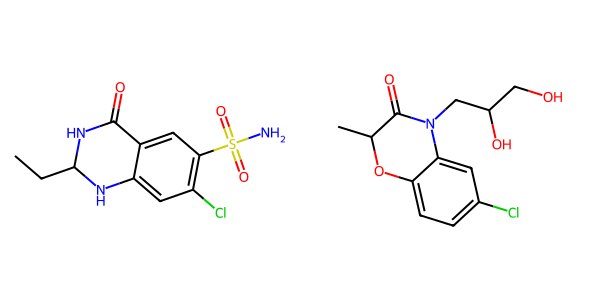

In [24]:
dm.to_image(smis)

## Embeddings to SMILES

In [25]:
decoded_smi = trained_model.latent_to_smiles_batched(torch.tensor(embeds))

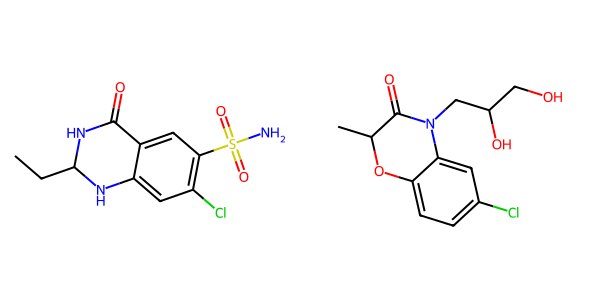

In [26]:
dm.to_image(decoded_smi)

## Plot randomly generated molecules

batch:  0
total generated:  10


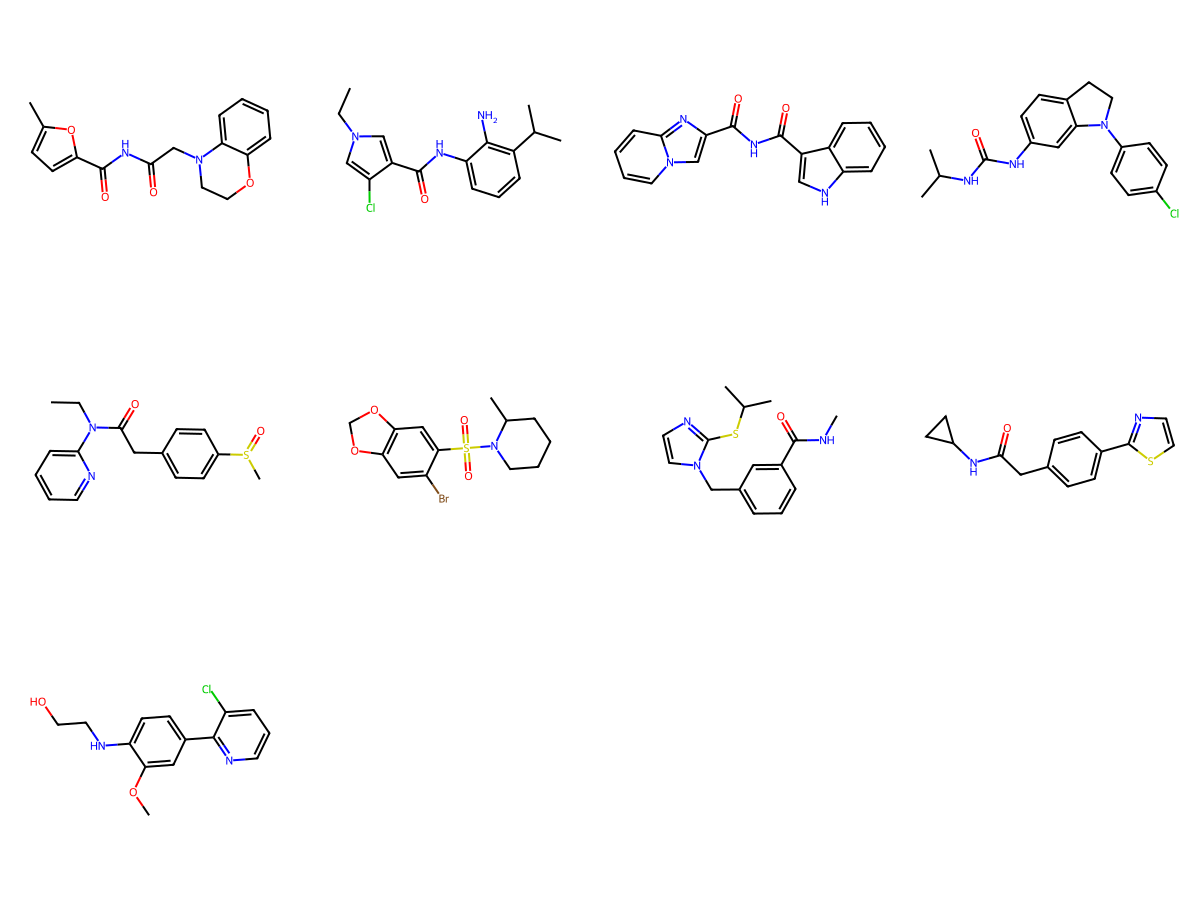

In [28]:
generated_smi = trained_model.multinomial_generation_batched(total=10, batch_size=10)
generated_smi = [i for i in generated_smi if i != None]
dm.to_image(generated_smi)